In [118]:
import torch
import torchvision.models as models
import torch.nn as nn

from google.colab import drive

drive.mount('/content/drive')

import numpy as np
from os import listdir

import pandas as pd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [119]:
from torch.utils.data import Dataset, DataLoader

class FullDataset(Dataset):
    def __init__(self, csv_file):
        df = pd.read_csv(csv_file)
        # Exclude columns from the dataset
        df = df.drop(columns=['name', 'city', 'description', 'image', 'images', 'categoryReviews', 'userReviews'])
        
        # Remove '[' and ']' from 'Dominate' and 'Color' columns
        df['Dominate'] = df['Dominate'].str.replace(r'\[|\]', '', regex=True)
        df['Color'] = df['Color'].str.replace(r'\[|\]', '', regex=True)
        print(df['Dominate'])
        df = df.dropna()
        df[['Dominate_1', 'Dominate_2', 'Dominate_3']] = df['Dominate'].str.split(expand=True).astype(float)
        df[['Color_1', 'Color_2', 'Color_3']] = df['Color'].str.split(expand=True).astype(float)

        # Drop the original 'Dominate' and 'Color' columns
        df = df.drop(columns=['Dominate', 'Color'])
        df = df.dropna()

        self.features = df.drop(columns=['price'])
        
        # def expand_list_to_columns(a, column):
        #   expanded = a[column].apply(pd.Series)
        #   expanded.columns = [f'{column}_{i+1}' for i in range(expanded.shape[1])]
        #   a = pd.concat([a, expanded], axis=1)
        #   a = a.drop(columns=[column])
        #   return a
        
        # self.features = expand_list_to_columns(self.features, 'Dominate')
        # self.features = expand_list_to_columns(self.features, 'Color')

        # print(self.features['Color_1'])
        # print(self.features['Dominate_1'])
        self.labels = df['price']

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        x = torch.tensor(self.features.iloc[index].values, dtype=torch.float32)
        y = torch.tensor(self.labels.iloc[index], dtype=torch.float32)

        return x, y

class FullModel(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, output_size):
        super(FullModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        # self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        # self.fc3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.fc4 = nn.Linear(hidden_size_1, output_size)
        self.dropout = nn.Dropout(0)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        # self.dropout(x)
        # x = torch.relu(self.fc2(x))
        # self.dropout(x)
        # x = torch.relu(self.fc3(x))
        self.dropout(x)
        x = self.fc4(x)
        return x


In [120]:
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import random

random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

csv_file = "/content/drive/MyDrive/Copy of final_data_plus_features.csv"

batch_size = 256
hidden_sizes = [256, 128, 64]
output_size = 1  # Assuming 'price' is a single-value label
num_epochs = 10
learning_rate = 0.0001
weight_decay= 1e-4

# Load and split the dataset
dataset = FullDataset(csv_file)
train_data, val_data = train_test_split(dataset, test_size=0.2)
val_data, test_data = train_test_split(val_data, test_size=0.5)

input_size = dataset[0][0].size(0)
print(dataset[0][0].size(0))

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)

model = FullModel(input_size, *hidden_sizes, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loop
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    # Train
    model.train()
    train_loss = 0.0
    for batch in train_dataloader:
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            inputs, labels = batch
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)
    
    print("Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}".format(epoch+1, num_epochs, train_loss, val_loss))

# Test
model.eval()
test_loss = 0.0
with torch.no_grad():
    for batch in test_dataloader:
        inputs, labels = batch
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
    test_loss /= len(test_dataloader)
    print("Test Loss: {:.4f}".format(test_loss))

0          200.57826 200.7613  203.15504
1          19.295359 15.373721 14.762594
2          170.05089 169.21521 166.77252
3          183.58603 179.1546  161.714  
4       110.95356   77.24888   60.295742
                      ...               
2983       174.98586 170.27669 169.48189
2984       44.07484  38.75437  35.979973
2985          95.89696 88.01665 77.69004
2986       79.61572  74.024315 64.25743 
2987                                 NaN
Name: Dominate, Length: 2988, dtype: object
3649
Epoch [1/10], Train Loss: 1.1807, Val Loss: 0.9405


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([85])) that is different to the input size (torch.Size([85, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([43])) that is different to the input size (torch.Size([43, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, 

Epoch [2/10], Train Loss: 0.6582, Val Loss: 0.7474
Epoch [3/10], Train Loss: 0.5337, Val Loss: 0.6335
Epoch [4/10], Train Loss: 0.4885, Val Loss: 0.4963
Epoch [5/10], Train Loss: 0.4383, Val Loss: 0.4259
Epoch [6/10], Train Loss: 0.4170, Val Loss: 0.4095
Epoch [7/10], Train Loss: 0.4072, Val Loss: 0.4070
Epoch [8/10], Train Loss: 0.4019, Val Loss: 0.3950
Epoch [9/10], Train Loss: 0.3967, Val Loss: 0.4166
Epoch [10/10], Train Loss: 0.4021, Val Loss: 0.3957
Test Loss: 0.3780


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


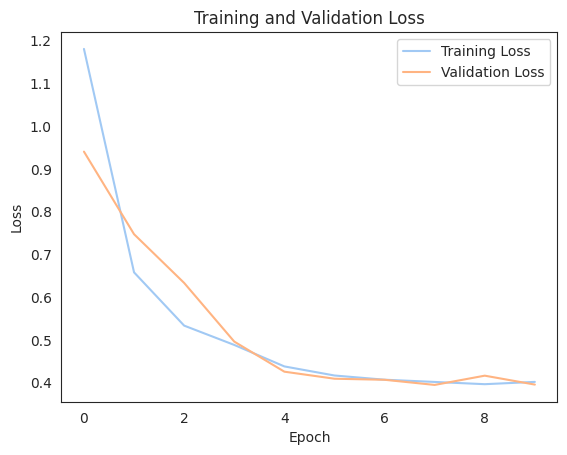

In [121]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

-0.04853725790246788


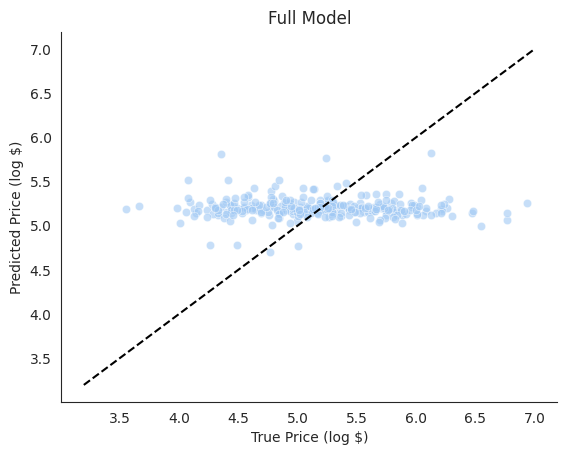

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

predictions = []
targets = []
model.eval()

with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(test_dataloader):
        outputs = model(inputs)
        predictions.append(outputs.numpy())
        targets.append(labels.numpy())

predictions = np.concatenate(predictions, axis=0)
y_test = np.array(targets)

predictions = predictions.reshape(-1)
y_test = y_test.reshape(-1)
# print(predictions)

# print(y_test)
# plot the data
sns.set_style("white")
sns.set_palette("pastel")
print(r2_score(y_test, predictions))
sns.scatterplot(x=y_test, y=predictions, alpha=0.6)
x_range = np.linspace(3.2, 7, 10)
sns.lineplot(x=x_range, y=x_range, color='k', ls="--")
plt.xlabel("True Price (log $)")
plt.ylabel("Predicted Price (log $)")
plt.title("Full Model")
sns.despine()
plt.savefig("full_model.png", dpi=200)
plt.show()

-0.06015500611641511


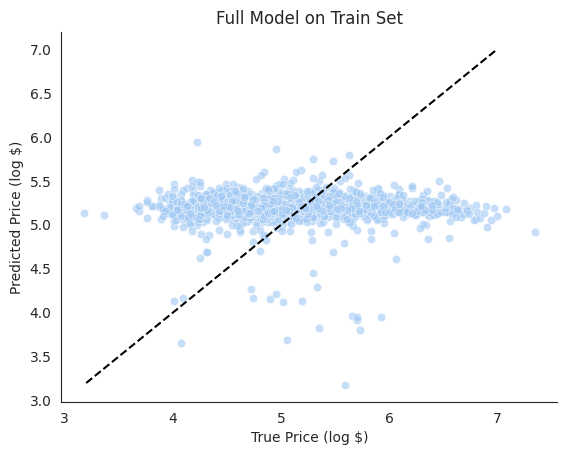

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

predictions = []
targets = []
model.eval()

train_dataloader = DataLoader(train_data, batch_size=1)

with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(train_dataloader):
        outputs = model(inputs)
        predictions.append(outputs.numpy())
        targets.append(labels.numpy())

predictions = np.concatenate(predictions, axis=0)
y_test = np.array(targets)

predictions = predictions.reshape(-1)
y_test = y_test.reshape(-1)

# print(predictions)

# print(y_test)
# plot the data
sns.set_style("white")
sns.set_palette("pastel")
print(r2_score(y_test, predictions))
sns.scatterplot(x=y_test, y=predictions, alpha=0.6)
x_range = np.linspace(3.2, 7, 10)
sns.lineplot(x=x_range, y=x_range, color='k', ls="--")
plt.xlabel("True Price (log $)")
plt.ylabel("Predicted Price (log $)")
plt.title("Full Model on Train Set")
sns.despine()
plt.savefig("full_model.png", dpi=200)
plt.show()